In [15]:
import pandas as pd
import time
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

train_data = pd.read_csv('./dataset/train.csv')
predict_data = pd.read_csv('./dataset/test_withoutLable.csv')

diabetes_train_data_X = train_data.drop(['ID', 'Diabetes_binary', 'Sex', 'NoDocbcCost', 'AnyHealthcare', 'HvyAlcoholConsump', 'Veggies', 'Fruits', 'CholCheck'], axis=1)
diabetes_train_data_Y = train_data['Diabetes_binary']
diabetes_predict_data = predict_data.drop(['ID', 'Sex', 'NoDocbcCost', 'AnyHealthcare', 'HvyAlcoholConsump', 'Veggies', 'Fruits', 'CholCheck'], axis=1)

train_data, test_data, train_label, test_label = train_test_split(diabetes_train_data_X, diabetes_train_data_Y, test_size=0.2)

train_data = torch.from_numpy(train_data.values).float()
train_label = torch.from_numpy(train_label.values).float()
test_data = torch.from_numpy(test_data.values).float()
test_label = torch.from_numpy(test_label.values).float()
predict_data = torch.from_numpy(diabetes_predict_data.values).float()

train_dataset = TensorDataset(train_data, train_label)
test_dataset = TensorDataset(test_data, test_label)

trainLoader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers=1)
testLoader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False, num_workers=1)


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(14, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.Dropout(p=0.1),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.Dropout(p=0.1),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 8),
            torch.nn.ReLU(),
            torch.nn.Linear(8, 2),
            torch.nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        return self.fc(x)

net = Net()

print(net)

Net(
  (fc): Sequential(
    (0): Linear(in_features=14, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=64, bias=True)
    (6): Dropout(p=0.1, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=16, bias=True)
    (9): ReLU()
    (10): Linear(in_features=16, out_features=8, bias=True)
    (11): ReLU()
    (12): Linear(in_features=8, out_features=2, bias=True)
    (13): Softmax(dim=1)
  )
)


In [22]:
criterion = torch.nn.CrossEntropyLoss() # 损失函数
optimizer = torch.optim.SGD(net.parameters(), lr=0.01) # 优化器

start = time.time()
net.train()
for epoch in range(20):
    running_loss = 0.0
    for i, data in enumerate(trainLoader, 0):
        # 获取数据
        inputs, labels = data
        # 梯度清零
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels.long())
        # 反向传播
        loss.backward()
        # 更新梯度
        optimizer.step()
        
        running_loss += loss.item()
        if i % 20 == 19:
            print('[%d, %5d] loss: %.5f' % (epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

print('Finished Training, Total cost time: ', time.time()-start)

[1,    20] loss: 0.00555
[1,    40] loss: 0.00561
[1,    60] loss: 0.00549
[1,    80] loss: 0.00536
[1,   100] loss: 0.00561
[1,   120] loss: 0.00562
[1,   140] loss: 0.00544
[1,   160] loss: 0.00555
[1,   180] loss: 0.00549
[1,   200] loss: 0.00572
[1,   220] loss: 0.00547
[1,   240] loss: 0.00559
[1,   260] loss: 0.00551
[1,   280] loss: 0.00559
[1,   300] loss: 0.00543
[1,   320] loss: 0.00553
[1,   340] loss: 0.00549
[1,   360] loss: 0.00547
[1,   380] loss: 0.00561
[1,   400] loss: 0.00541
[1,   420] loss: 0.00548
[1,   440] loss: 0.00564
[1,   460] loss: 0.00546
[1,   480] loss: 0.00556
[1,   500] loss: 0.00560
[1,   520] loss: 0.00548
[1,   540] loss: 0.00558
[1,   560] loss: 0.00547
[1,   580] loss: 0.00552
[1,   600] loss: 0.00581
[1,   620] loss: 0.00558
[2,    20] loss: 0.00553
[2,    40] loss: 0.00558
[2,    60] loss: 0.00558
[2,    80] loss: 0.00568
[2,   100] loss: 0.00563
[2,   120] loss: 0.00544
[2,   140] loss: 0.00551
[2,   160] loss: 0.00562
[2,   180] loss: 0.00551


Accuracy of the network on the 8000 train images: 74.64000 %


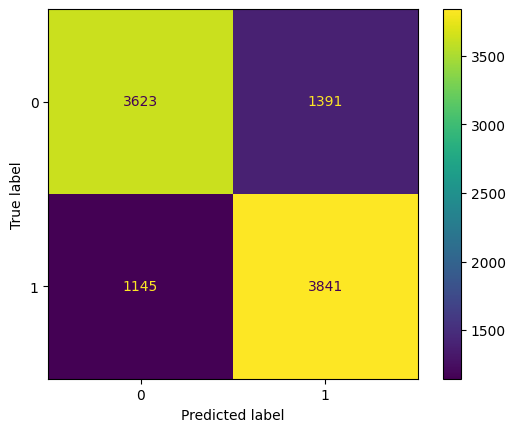

In [26]:
correct = 0
total = 0

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = []

with torch.no_grad():
    for data in testLoader:
        inputs, labels = data
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted = (outputs >= 0.80).long()[:,1]
        predictions.extend(predicted)
        total += labels.size(0)
        correct += (predicted == labels.long()).sum().item()

cm = confusion_matrix(test_label, predictions)
ConfusionMatrixDisplay(cm).plot()

print('Accuracy of the network on the 8000 train images: %.5f %%' % (100 * correct / total))

In [13]:
net.eval()
with torch.no_grad():
        outputs = net(predict_data)
        predicted = (outputs >= 0.80).long()[:,1]
        predicted = predicted.numpy()

submission = pd.read_csv('./dataset/test_withoutLable.csv')
submission = submission[['ID']]
submission['Diabetes_binary'] = predicted
submission.to_csv('./dataset/submission.csv', index=False)
print('ok')

ok
